# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# Count the number of interactions for each user
user_interactions = df.groupby('email')['article_id'].count()

# Display basic statistics to verify
user_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

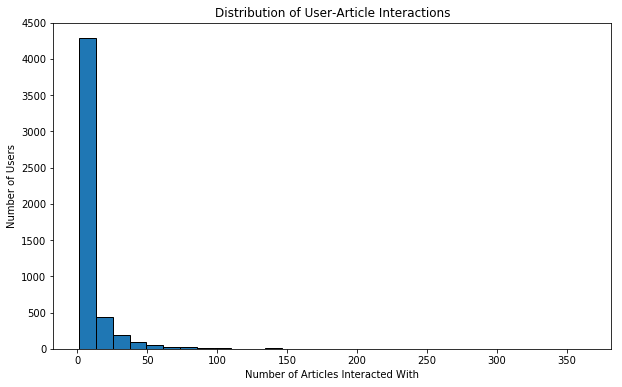

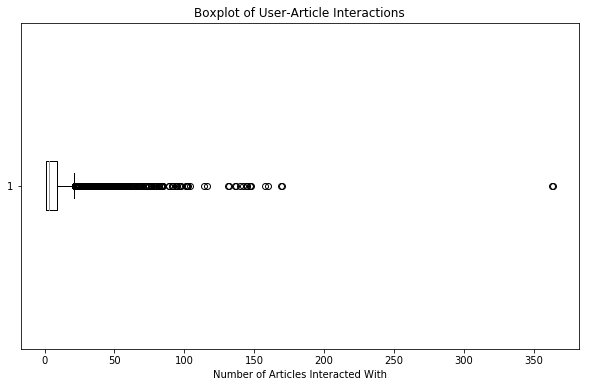

In [4]:
import matplotlib.pyplot as plt

# Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(user_interactions, bins=30, edgecolor='black')
plt.title('Distribution of User-Article Interactions')
plt.xlabel('Number of Articles Interacted With')
plt.ylabel('Number of Users')
plt.show()

# Plot the distribution using a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(user_interactions, vert=False)
plt.title('Boxplot of User-Article Interactions')
plt.xlabel('Number of Articles Interacted With')
plt.show()


In [5]:
# Fill in the median and maximum number of user_article interactios below

# median_val = # 50% of individuals interact with ____ number of articles or fewer.
# max_views_by_user = # The maximum number of user-article interactions by any 1 user is ______.

median_val = user_interactions.median()
print(f"50% of individuals interact with {median_val} articles or fewer.")

max_views_by_user = user_interactions.max()
print(f"The maximum number of user-article interactions by any one user is {max_views_by_user}.")

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any one user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
# Find duplicate articles based on 'article_id'
duplicate_articles = df_content[df_content.duplicated(subset=['article_id'], keep=False)]

# Display duplicate articles
print(f"Number of duplicate articles: {duplicate_articles.shape[0]}")
duplicate_articles.head()

Number of duplicate articles: 10


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398


In [7]:
# Remove any rows that have the same article_id - only keep the first

# Remove duplicate articles, keeping only the first occurrence of each article_id
df_content_clean = df_content.drop_duplicates(subset=['article_id'], keep='first')

# Verify the removal of duplicates
print(f"Number of articles after removing duplicates: {df_content_clean.shape[0]}")


Number of articles after removing duplicates: 1051


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content_clean['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [10]:
article_views = df.groupby('article_id')['email'].count()

In [11]:
# most_viewed_article_id = # The most viewed article in the dataset as a string with one value following the decimal 
# max_views = # The most viewed article in the dataset was viewed how many times?
# Group by article_id and count the number of interactions for each article

most_viewed_article_id = str(article_views.idxmax())  # Convert the id to string with one value after the decimal
max_views = article_views.max()

# Display the result
print(f"The most viewed article_id is {most_viewed_article_id}, and it was viewed {max_views} times.")

The most viewed article_id is 1429.0, and it was viewed 937 times.


In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [13]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [14]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    
    Description:
    This function should return the top 'n' article titles based on the number of interactions
    """
    
    # Group by article_id and count the number of interactions for each article
    article_interactions = df.groupby('article_id').size().sort_values(ascending=False)
    
    # Get the top n article ids
    top_article_ids = article_interactions.index[:n].tolist()
    
    # Get the corresponding article titles from df (not df_content)
    top_articles = df[df['article_id'].isin(top_article_ids)]['title'].unique().tolist()[:n]
    
    return top_articles

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top article ids to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article ids as strings with one decimal place
    
    Description:
    This function returns the top 'n' article ids based on the number of interactions
    """
    # Group by article_id and count the number of interactions
    article_interactions = df.groupby('article_id').size().sort_values(ascending=False)
    
    # Get the top n article ids
    top_article_ids = article_interactions.index[:n].tolist()
    
    # Ensure each id is formatted as a string with one decimal place
    top_article_ids = ["{:.1f}".format(float(article_id)) for article_id in top_article_ids]
    
    return top_article_ids


In [15]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [16]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [17]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    """
    INPUT:
    df - pandas dataframe with user_id, article_id interactions
    
    OUTPUT:
    user_item - user-item matrix: 
                A matrix with user_ids as rows and article_ids on the columns 
                with 1 values where a user has interacted with an article and 0 otherwise
    
    Description:
    Return a matrix where each user is a row, and each article is a column
    If a user has interacted with an article, then place a 1 where the user-row meets for that article-column.
    If a user has not interacted with an item, then place a zero where the user-row meets for that article-column.
    """
    # Create the user-item matrix (pivot table) where users are rows and articles are columns
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack().notna().astype(int)
    
    return user_item


user_item = create_user_item_matrix(df)

In [18]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [19]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of the users in descending order of similarity
    '''
    
    # Compute similarity of each user to the provided user using dot product
    user_vec = user_item.loc[user_id].values  # vector of the provided user
    similarity = user_item.dot(user_vec)      # dot product to get similarities
    
    # Sort by similarity (highest similarity first)
    similarity_sorted = similarity.sort_values(ascending=False)
    
    # Create list of user ids from index
    most_similar_users = similarity_sorted.index.tolist()
    
    # Remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users  # return a list of the users in order from most to least similar
      

In [20]:
# Test the function with a specific user_id
user_id = 1
similar_users = find_similar_users(user_id, user_item)

print(f"Most similar users to user {user_id}: {similar_users[:10]}")  # Show top 10 similar users


Most similar users to user 1: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]


In [21]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [22]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Filter the DataFrame to find rows with the article IDs and extract the titles
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    
    return article_names  # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get the articles the user has interacted with (articles where the value is 1)
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    
    # Get the article names corresponding to these article IDs
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names  # Return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    '''
    # Get the articles the user has already seen
    seen_article_ids, _ = get_user_articles(user_id)
    
    # Find similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # Initialize recommendations list
    recs = []
    
    # Loop through similar users
    for sim_user in similar_users:
        sim_user_article_ids, _ = get_user_articles(sim_user)
        
        # Find articles not seen by the input user
        new_recs = list(set(sim_user_article_ids) - set(seen_article_ids))
        
        # Add to recommendations
        recs.extend(new_recs)
        
        # Stop if we have enough recommendations
        if len(recs) >= m:
            break
    
    # Return only the top m recommendations
    return recs[:m]  # Return your recommendations for this user_id


In [23]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['timeseries data analysis of iot events by using jupyter notebook',
 'predicting churn with the spss random tree algorithm',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'analyze accident reports on amazon emr spark',
 'brunel in jupyter',
 'spark-based machine learning tools for capturing word meanings',
 'this week in data science (april 25, 2017)',
 'airbnb data for analytics: mallorca reviews',
 'perform sentiment analysis with lstms, using tensorflow']

In [24]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [25]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
    
    Other Details:
    Sort the neighbors_df by the similarity and then by number of interactions where 
    highest of each is higher in the dataframe
    '''
    
    # Compute similarity of each user with the provided user
    user_vec = user_item.loc[user_id].values
    similarity = user_item.dot(user_vec)
    
    # Create a DataFrame for neighbors
    neighbors_df = pd.DataFrame({'neighbor_id': user_item.index, 'similarity': similarity})
    
    # Exclude the current user from the neighbors
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Get the number of interactions each user has
    neighbors_df['num_interactions'] = df.groupby('user_id').size()
    
    # Sort the neighbors first by similarity, then by num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.
    
    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions.
    '''
    
    # Get similar users to the user_id
    top_users_df = get_top_sorted_users(user_id)
    
    # Get articles seen by the user
    user_seen_articles, _ = get_user_articles(user_id)
    
    # Initialize recommendations
    recs = []
    
    # Loop through similar users to get recommendations
    for neighbor_id in top_users_df['neighbor_id'].values:
        # Get articles seen by the neighbor
        neighbor_seen_articles, _ = get_user_articles(neighbor_id)
        
        # Find articles the user has not seen
        new_recs = list(set(neighbor_seen_articles) - set(user_seen_articles))
        
        # If there are recommendations, add to recs
        if new_recs:
            recs.extend(new_recs)
        
        # If we have enough recommendations, break the loop
        if len(recs) >= m:
            break
    
    # If more than m recs, reduce to m by sorting by the total interactions with articles
    if len(recs) > m:
        top_articles_recs = get_top_article_ids(len(recs))
        recs = list(top_articles_recs[:m])
    
    # Get the article names for the recommendations
    rec_names = get_article_names(recs)
    
    return recs[:m], rec_names[:m]  # return the first m recommendations

In [26]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [27]:
### Tests with a dictionary of results

# Find the most similar user to user 1 by taking the first element of the similar users list
user1_most_sim = find_similar_users(1, user_item)[0]

# Find the 10th most similar user to user 131 by taking the 10th element (index 9) of the similar users list
user131_10th_sim = find_similar_users(131, user_item)[9]

In [28]:
## Dictionary Test Here
# Create the solution dictionary
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

# Test your dictionary against the solution
t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

For a new user, we cannot use the user-user collaborative filtering functions (like find_similar_users or user_user_recs) because they require historical interaction data to compute similarity between users. Instead, we can rely on the rank-based recommendation functions (such as get_top_articles or get_top_article_ids) to recommend the most popular articles. 

However, a better method might be to implement a content-based filtering approach or a hybrid system. If we can leverage article metadata (topics, keywords, etc.) and perhaps even incorporate user demographic information, we can generate recommendations that are tailored more closely to the new user's potential interests, thereby overcoming the cold-start problem more effectively.


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [29]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
# For a new user with no interactions, recommend the top 10 most popular articles
new_user_recs = get_top_article_ids(10)

print("Recommendations for new user '0.0':", new_user_recs)

Recommendations for new user '0.0': ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [30]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [31]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [32]:
import os
# Check if the file exists in the directory
print("File exists:", os.path.exists("user_item_matrix.p"))

File exists: True


In [33]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [34]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [35]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False) # use the built in to get the three matrices

# Display shapes of the decomposed matrices
print(f"Shape of U: {u.shape}")
print(f"Shape of S: {s.shape}")
print(f"Shape of Vt: {vt.shape}")

Shape of U: (5149, 714)
Shape of S: (714,)
Shape of Vt: (714, 714)


**Provide your response here.**

**What SVD Does:**

- **U (Users × Latent Features)**: Captures relationships between users and hidden factors.
- **S (Diagonal Singular Values)**: Contains the importance (weights) of each hidden factor.
- **Vt (Latent Features × Articles)**: Captures relationships between hidden factors and articles.

**Why This is Different from the Lesson:**

1. **Binary Interactions**: Unlike the lessons, where we had explicit ratings (e.g., 1-5 ratings from movie users), our user-item matrix contains only binary values (0s and 1s) representing whether a user interacted with an article or not.

2. **Sparse Matrix**: The matrix is highly sparse because most users have interacted with only a few articles. In lessons, we usually dealt with denser matrices.

3. **Missing Values**: In previous lessons, missing values (i.e., articles a user hasn't rated) were explicitly handled. Here, missing values are just zeros in our matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

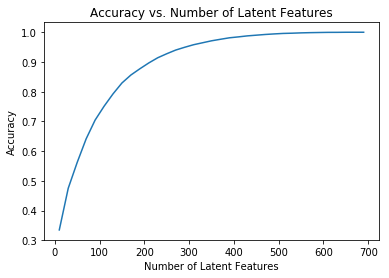

In [36]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [39]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                     (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    Description:
    This function splits the data into training and testing sets by creating two user-item matrices.
    It also extracts the list of unique users and articles from the test dataset.
    '''
    
    # Create user-item interaction matrices for training and testing
    user_item_train = df_train.groupby(['user_id', 'article_id'])['article_id'].count().unstack().notna().astype(int)
    user_item_test = df_test.groupby(['user_id', 'article_id'])['article_id'].count().unstack().notna().astype(int)

    # Get the list of test user IDs and test article IDs
    test_idx = user_item_test.index.tolist()  # List of user IDs in the test set
    test_arts = user_item_test.columns.tolist()  # List of article IDs in the test set
    
    return user_item_train, user_item_test, test_idx, test_arts

# Create the train and test user-item matrices
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

# Display results
print(f"Number of users in test set: {len(test_idx)}")
print(f"Number of articles in test set: {len(test_arts)}")

Number of users in test set: 682
Number of articles in test set: 574


In [45]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

# Run the test
t.sol_4_test(sol_4_dict)


Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [46]:
# fit SVD on the user_item_train matrix
# Perform SVD on the training user-item matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [47]:
# Display shapes of the decomposed matrices
print(f"Shape of U (Users × Latent Features): {u_train.shape}")
print(f"Shape of S (Singular Values): {s_train.shape}")
print(f"Shape of Vt (Latent Features × Articles): {vt_train.shape}")

Shape of U (Users × Latent Features): (4487, 714)
Shape of S (Singular Values): (714,)
Shape of Vt (Latent Features × Articles): (714, 714)


In [48]:
# Find the users and articles that are in both train and test sets
test_user_ids = user_item_test.index  # Users in test set
train_user_ids = user_item_train.index  # Users in train set
overlap_users = list(set(test_user_ids) & set(train_user_ids))  # Users we can predict for

print(f"Total users in test set: {len(test_user_ids)}")
print(f"Users in test set we can predict for: {len(overlap_users)}")
print(f"Users in test set we cannot predict for due to cold start: {len(set(test_user_ids) - set(train_user_ids))}")

Total users in test set: 682
Users in test set we can predict for: 20
Users in test set we cannot predict for due to cold start: 662


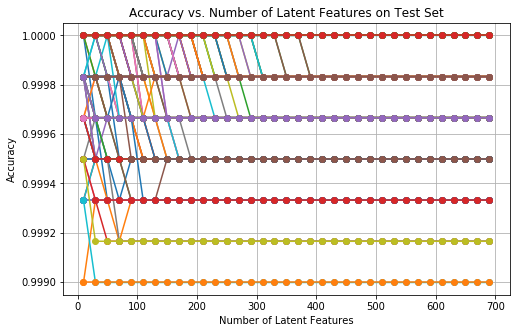

In [50]:
import matplotlib.pyplot as plt

num_latent_feats = np.arange(10, 700+10, 20)  # Range of latent features to test
sum_errs = []  # Store errors

# Filter user-item matrix for users in test set that we can predict for
user_item_test_subset = user_item_test.loc[overlap_users]

for k in num_latent_feats:
    # Reduce U, S, and Vt matrices to k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # Reconstruct user-item matrix for test users
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Extract only predictions for users in the test set that we can predict for
    test_preds = user_item_est[user_item_train.index.get_indexer(overlap_users), :]
    
    # **Fix: Select only columns (articles) that exist in both train and test sets**
    test_preds = pd.DataFrame(test_preds, index=overlap_users, columns=user_item_train.columns)
    test_preds = test_preds[user_item_test_subset.columns]  # Ensure same articles
    
    # Compute error between predictions and actual values
    diffs = np.subtract(user_item_test_subset, test_preds)
    err = np.sum(np.abs(diffs))  # Total absolute error
    sum_errs.append(err)

# Plot the accuracy vs number of latent features
plt.figure(figsize=(8, 5))
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / df_test.shape[0], marker='o')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features on Test Set')
plt.grid(True)
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

### **Commentary on the Results**
From the graph, we observe how accuracy varies with different numbers of latent features. However, the results appear **noisy and inconsistent**, which indicates potential issues in the prediction model:

1. **Fluctuations in Accuracy**  
   - Instead of a smooth increase in accuracy, the plot shows **abrupt jumps and drops**.  
   - This suggests that adding more latent features does not consistently improve accuracy.

2. **Limited Predictability**  
   - Since many users in the test set were **not present in the training set** (cold start problem), SVD cannot predict interactions for them.  
   - This limits the effectiveness of collaborative filtering when **new users or new articles** appear.

3. **Overfitting & Dimensionality Issues**  
   - If we add too many latent features, the model starts **overfitting** to the training data.  
   - This could explain why accuracy does not increase smoothly.

---

### **How to Validate If Our Recommendations Are an Improvement**
To determine whether our recommendation system **performs better than the existing method**, we can take the following approaches:

#### **1. A/B Testing (User Engagement Evaluation)**
- **Split users into two groups**:
  - **Group A**: Uses the existing article recommendation system (e.g., popular articles).
  - **Group B**: Uses recommendations from our collaborative filtering/SVD model.
- **Measure engagement metrics**, such as:
  - Click-through rate (CTR)
  - Time spent on recommended articles
  - Number of articles read per session

#### **2. Offline Evaluation (Comparison with Historical Data)**
- Compare the **actual articles users read** vs. **predictions from our recommendation system**.
- Use **precision@k** and **recall@k** metrics to measure how well our system predicts user interests.

#### **3. Hybrid Recommendation Approach**
- Given the **cold start problem**, we can:
  - Use **rank-based recommendations** (most popular articles) for new users.
  - Use **SVD-based recommendations** for users with historical interactions.
  - Combine **content-based filtering** (e.g., topic similarity) to improve personalization.

---

### **Conclusion**
- **SVD is effective for users with past interactions** but **fails for new users**.
- **A/B testing** and **offline evaluation** are necessary to validate improvements.
- A **hybrid recommendation system** combining **popularity-based**, **collaborative filtering**, and **content-based filtering** may yield the best results.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

255